In [1]:
from huggingface_hub import notebook_login

notebook_login()

In [2]:
import torch

from transformers import AutoProcessor, Qwen2_5_VLForConditionalGeneration
from datasets import load_dataset, load_from_disk, Dataset

In [3]:
# import json

# dataset_path = "/lid/home/saydalie/multimodal_cot/VLM-R1/data/DrivingVQA/test.json"

# with open(dataset_path, "r") as f:
#     data = json.load(f)

In [11]:
model_name_or_path = "Qwen/Qwen2.5-VL-7B-Instruct"

model = Qwen2_5_VLForConditionalGeneration.from_pretrained(model_name_or_path, torch_dtype=torch.float16, device_map="auto")
processor = AutoProcessor.from_pretrained(model_name_or_path)

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

In [121]:
from qwen_vl_utils import process_vision_info


def generate_text_from_sample(model, processor, sample, max_new_tokens=1024, device="cuda"):
    # Prepare the text input by applying the chat template
    text_input = processor.apply_chat_template(
        sample, tokenize=False, add_generation_prompt=False  # Use the sample without the system message
    )
    print(text_input)

    # Process the visual input from the sample
    image_inputs, _ = process_vision_info(sample)

    # Prepare the inputs for the model
    model_inputs = processor(
        text=[text_input],
        images=image_inputs,
        return_tensors="pt",
    ).to(
        device
    )

    # Generate text with the model
    generated_ids = model.generate(**model_inputs, max_new_tokens=max_new_tokens)

    # Trim the generated ids to remove the input ids
    trimmed_generated_ids = [out_ids[len(in_ids) :] for in_ids, out_ids in zip(model_inputs.input_ids, generated_ids)]

    # Decode the output text
    output_text = processor.batch_decode(
        trimmed_generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )

    return image_inputs[0], output_text[0]  # Return the first decoded output text

In [137]:
train_dataset = [
    {
        'image': '/lid/home/saydalie/multimodal_cot/VLM-R1/data/images/0014.jpg',
        'query': 'In this situation, I can drive at what speed? Options: 70 km/h, 80 km/h, 90 km/h, 100 km/h. Select all right answers.'
    }
]

system_message = """You are a Vision Language Model specialized in interpreting grounded visual data from images.
Your task is to analyze the provided image and respond to queries with grounding the image with coordinates of bounding boxes of each element in the image.
Focus on delivering accurate, succinct answers based on the visual information. Always include bounding boxes of each element in your response"""

def format_data(sample):
    return [
        {
            "role": "system",
            "content": [{"type": "text", "text": system_message}],
        },
        {
            "role": "user",
            "content": [
                {
                    "type": "image",
                    "image": f"file://{sample['image']}",
                },
                {
                    "type": "text",
                    "text": sample["query"],
                },
            ],
        }
    ]
train_dataset = [format_data(sample) for sample in train_dataset]

In [138]:
image_input, output = generate_text_from_sample(model, processor, train_dataset[0])
output

<|im_start|>system
You are a Vision Language Model specialized in interpreting grounded visual data from images.
Your task is to analyze the provided image and respond to queries with grounding the image with coordinates of bounding boxes of each element in the image.
Focus on delivering accurate, succinct answers based on the visual information. Always include bounding boxes of each element in your response<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>In this situation, I can drive at what speed? Options: 70 km/h, 80 km/h, 90 km/h, 100 km/h. Select all right answers.<|im_end|>



' addCriterion\nThe speed limit in the image is 90 km/h, as indicated by the speed limit sign on the right side of the road.\n\n```json\n[\n\t{"bbox_2d": [324, 92, 336, 105], "label": "speed limit"}\n]\n```'

In [141]:
image_input.crop((324, 92, 336, 105))

<PIL.Image.Image image mode=RGB size=476x364 at 0x75215DB51840>


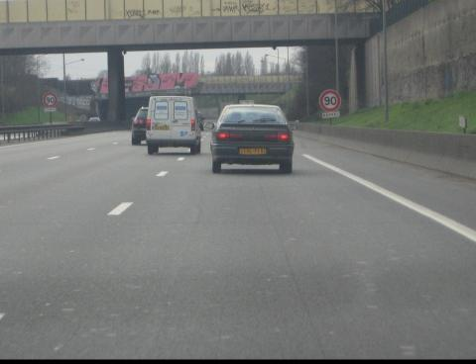

In [140]:
print(image_input)
image_input